In [1]:
import pickle
import torch
import torchtext.transforms as T
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

def loadFiles(file):
    with open(file, "rb") as file:
        data = pickle.load(file)
    print("The size of the dataset is:", len(data))
    return data


def separateData(data):
    X = data[:, 0]
    y = data[:, 1]
    return X, y

In [2]:
data = loadFiles(r'./english-german-both.pkl')

The size of the dataset is: 10000


In [3]:
eng, germ = separateData(data)

In [4]:
def findLongestSequence(sentList):
    return max(len(seq.split()) for seq in sentList)


In [5]:
enTokenizer = get_tokenizer('spacy', language='en')
deTokenizer = get_tokenizer('spacy', language='de')
def yieldTokensEn(data):
    for text in data:
        yield enTokenizer(text[:-1])

def yieldTokensDe(data):
    
    for text in data:
        yield deTokenizer(text[:-1])

/home/scotty/.local/lib/python3.10/site-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(
/home/scotty/.local/lib/python3.10/site-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "de" could not be loaded, trying "de_core_news_sm" instead
  warnings.warn(


In [6]:
vocabEn = build_vocab_from_iterator(yieldTokensEn(eng), specials=["<pad>", "<sos>", "<eos>", "<unk>"], special_first=True)
vocabDe = build_vocab_from_iterator(yieldTokensDe(germ), specials=["<pad>", "<sos>", "<eos>", "<unk>"], special_first=True)

In [7]:
textPipelineEn = lambda x: vocabEn(enTokenizer(x))
textPipelineDe = lambda x: vocabDe(deTokenizer(x))

In [8]:
from sklearn.model_selection import train_test_split

trainEn, testEn, trainDe, testDe = train_test_split(eng, germ, test_size=0.1)
trainEn, valEn, trainDe, valDe = train_test_split(eng, germ, test_size=0.1)

In [9]:
BATCH_SIZE = 32
PAD_IDX = vocabEn(['<pad>'])[0]
SOS_IDX = vocabEn(['<sos>'])
EOS_IDX = vocabEn(['<eos>'])
print(PAD_IDX)
print(SOS_IDX)
print(EOS_IDX)

0
[1]
[2]


In [10]:
from torch.nn.utils.rnn import pad_sequence

def generateData(eng, deu):
    data = []
    for en, de in zip(eng, deu):
        enTensor = torch.tensor(textPipelineEn(en[:-1]), dtype=torch.long)
        deTensor = torch.tensor(textPipelineDe(de[:-1]), dtype=torch.long)
        data.append((enTensor, deTensor))
    return data


trainData = generateData(trainEn, trainDe)
valData = generateData(valEn, valDe)         
testData = generateData(testEn, testDe)        

In [11]:
from torch.utils.data import DataLoader

    
def generateBatch(data_batch):
  de_batch, en_batch = [], []
  # print(data_batch)
  for (de_item, en_item) in data_batch:
    de_batch.append(torch.cat([torch.tensor(SOS_IDX), de_item, torch.tensor(EOS_IDX)], dim=0))
    en_batch.append(torch.cat([torch.tensor(SOS_IDX), en_item, torch.tensor(EOS_IDX)], dim=0))
  deLength = len(de_batch)
  batch = pad_sequence(en_batch + de_batch, padding_value=PAD_IDX, batch_first=True)
  en_batch, de_batch = batch[:deLength], batch[deLength:]
  return de_batch, en_batch


trainIter = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generateBatch)
valIter =  DataLoader(valData, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generateBatch)
testIter = DataLoader(testData, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generateBatch)

In [12]:
from transformer import Transformer
from positenc import PositionalEncodingTorch
from torch.nn import Embedding, Module, Linear

EMB_DIM = 512
HEADS = 4
LINEAR_DIM = 2048
DROPOUT = 0.1
LAYERS = 6
BETA_1 = 0.9
BETA_2 = 0.98
EPSILON = 10**-9
ENG_VOCAB_LEN = vocabEn.__len__()
DE_VOCAB_LEN = vocabDe.__len__()
print(f"The english has {ENG_VOCAB_LEN} words.")
print(f"The german has {DE_VOCAB_LEN} words.")

EN_MAX_SEQ_LEN, DE_MAX_SEQ_LEN = findLongestSequence(eng) + 2 , findLongestSequence(germ) + 2

#mask for the decoder
def createMask(x):
    batch, seq_length, _ = x.size()
    mask = torch.ones((batch, seq_length, seq_length))
    mask = torch.tril(mask, diagonal=0)
    return mask

def createMaskGen(x):
    x = x.unsqueeze(1)
    batch, _, seq_length = x.size()
    mask = torch.ones((batch, 1, seq_length))
    maskR = torch.logical_and(mask, x)
    maskC = torch.logical_and(x.transpose(-1, 1), mask.transpose(-1, 1))
    mask = torch.multiply(maskR, maskC)
    return mask
    


class TransformerModel(Module):
    def __init__(self):
        super().__init__()
        self.embEn = Embedding(ENG_VOCAB_LEN, EMB_DIM)
        self.embDe = Embedding(DE_VOCAB_LEN, EMB_DIM)
        self.positEn = PositionalEncodingTorch(EN_MAX_SEQ_LEN, EMB_DIM)
        self.positDe = PositionalEncodingTorch(DE_MAX_SEQ_LEN, EMB_DIM)
        self.transformer = Transformer(LAYERS, EMB_DIM, EMB_DIM, HEADS, LINEAR_DIM, DROPOUT)
        self.linear = Linear(EMB_DIM, DE_VOCAB_LEN)
        
    def forward(self, eng, de):
        mask1 = createMaskGen(eng)
        eng = self.embEn(eng)
        eng = self.positEn(eng)
        mask = createMaskGen(de)
        de = self.embDe(de)
        de = self.positDe(de)
        mask2 = createMask(de)
        mask2 = torch.logical_and(mask, mask2)
        dec = self.transformer(eng, de, mask1, mask2)
        lin = self.linear(dec)    
        return lin
        






The english has 2594 words.
The german has 4167 words.


In [13]:
class TransformerLRScheduler(object):
    def __init__(self,  warmup_steps:int=10, d_model:int=512):
        self.warmup_steps = warmup_steps
        self.d_model = d_model
    
    
    def __call__(self, epoch):
        epoch = epoch + 1
        minimum = min(epoch**-0.5, epoch * ((self.warmup_steps) ** (-1.5)))
        return (self.d_model**-0.5 ) * minimum
    

In [14]:
from torch import optim
import torch.nn as nn
from torch.optim import lr_scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerModel()
total_acc, total_count = 0, 0
optimizer = optim.Adam(model.parameters(), betas=(BETA_1, BETA_2), eps=EPSILON)
loss = nn.CrossEntropyLoss(ignore_index=0)
scheduler = TransformerLRScheduler(50)

In [15]:
def calculateAccuracy(testIter, loss, device):
    model.eval()
    

In [16]:
def validateModel(model, testIter, loss, device):
    lossPerBatch = []
    with torch.no_grad():
        model.eval()
        for i, (X, y) in enumerate(testIter):
            X, y = X.to(device), y.to(device)
            out = model(X[:, 1:], y[:, :-1])
            l = loss(out.contiguous().view(-1, 4167), y[:, 1:].contiguous().view(-1))
            lossPerBatch.append(l.item())
        meanLoss = sum(lossPerBatch)/len(lossPerBatch)
    return lossPerBatch, meanLoss

In [18]:
from tqdm import tqdm, trange



def train(model, trainIter, 
          testIter=valIter, 
          epochs=None, 
          loss=loss, 
          optimizer=optimizer, 
          device=device, 
          scheduler=scheduler):
    model.to(device)
    # pbar = trange(epochs, desc="Epochs ", unit="batches")
    # with tqdm(trainIter, unit="epochs") as tepoch:
    logs_dic = {
        "valildationLoss": [],
        "trainingLoss" : [],
        "validationAccuracy": [],
        "trainingAccuracy": []
    }
    for epoch in range(epochs):
        trainLossPerBatch = []
        with tqdm(trainIter, unit="batches") as tepoch:
            for i, (X,y) in enumerate(tepoch):
                model.train()
                optimizer.zero_grad()
                X, y = X.to(device), y.to(device)
                out = model(X[:, 1:], y[:, :-1])
                l = loss(out.contiguous().view(-1, 4167), y[:, 1:].contiguous().view(-1))
                trainLossPerBatch.append(l.item())
                tepoch.set_description(f"Epoch {epoch + 1}")            
                tepoch.set_postfix(loss=l.item())
                l.backward()
                optimizer.step()
                # break
            valLoss, meanValLoss = validateModel(model, testIter, loss=loss, device=device)
            print(f"The validation loss is: {meanValLoss}")
            logs_dic["valildationLoss"].append(valLoss)
            logs_dic["trainingLoss"].append(trainLossPerBatch)
            # print(f"Epoch: {epoch+1}     loss: {l}")
            if scheduler:
                if scheduler.__module__ == lr_scheduler.__name__:
                    scheduler.step()
                else:
                    for param_group in optimizer.param_groups:
                        lr = scheduler(epoch)
                        param_group['lr'] = lr
                
    return logs_dic
history = train(model, trainIter, testIter=valIter, epochs=100)

Epoch 1: 100%|██████████| 282/282 [02:51<00:00,  1.64batches/s, loss=5.54]


The validation loss is: 5.939326122403145


Epoch 2: 100%|██████████| 282/282 [02:50<00:00,  1.66batches/s, loss=4.32]


The validation loss is: 5.864408880472183


Epoch 3:  19%|█▉        | 54/282 [00:33<02:22,  1.60batches/s, loss=4.98]


KeyboardInterrupt: 

Text(0, 0.5, 'Learning Rate')

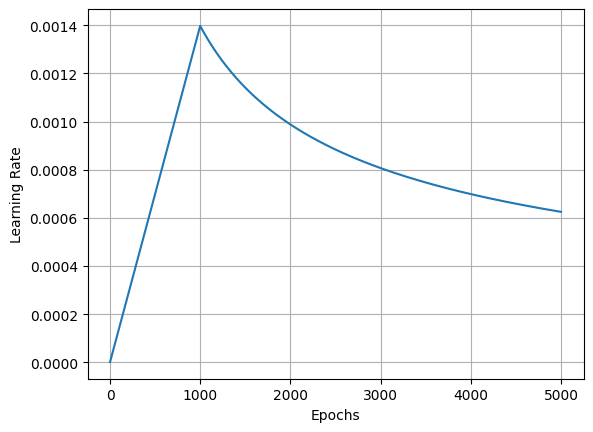

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

lr = TransformerLRScheduler(1000)
plt.plot([i for i in range(5000)], [lr(i) for i in range(5000)])
plt.grid()
plt.xlabel('Epochs')
plt.ylabel("Learning Rate")

In [ ]:
model = TransformerModel()

train(model, trainIter, epochs=1000, scheduler=None)




  0%|          | 0/2250 [00:00<?, ?batches/s]

Epoch 1:   0%|          | 0/2250 [00:00<?, ?batches/s, loss=8.49]

scaled_dots
tensor([[[[[-1.8200e+00, -8.4105e-01,  3.0387e+00, -2.1800e+00, -2.6519e+00,
            -3.2105e+00],
           [ 2.7057e-02, -7.8763e-01,  5.9496e-01,  1.6750e+00,  1.8411e+00,
             1.6573e+00],
           [ 9.2512e-01,  3.8983e-01,  8.5302e-01,  6.5406e-02,  9.9628e-02,
             1.6578e-01],
           [-1.3950e-01,  3.9592e-01,  3.0572e-01, -1.9451e+00, -2.1647e+00,
            -2.1650e+00],
           [-3.8584e-01,  4.1834e-01,  3.5335e-01, -2.2168e+00, -2.4892e+00,
            -2.5014e+00],
           [-7.5310e-01,  2.7917e-01,  7.1934e-01, -2.4993e+00, -2.8433e+00,
            -2.9359e+00]]],


         [[[ 5.9790e-01, -2.7583e-01,  1.6980e-01,  6.2286e-01,  5.0684e-01,
             2.9382e-01],
           [-5.0090e-01, -6.5529e-01, -7.9504e-01,  9.8022e-01,  1.3519e+00,
             1.7394e+00],
           [ 4.7326e-01,  2.6833e-01,  4.1850e-01,  6.0374e-01,  7.3417e-01,
             9.6190e-01],
           [ 8.3736e-01,  3.9913e-01,  7.5236e-01, -5.025

{'valildationLoss': [],
 'trainingLoss': [],
 'validationAccuracy': [],
 'trainingAccuracy': []}